#Import Libraries and Load Data

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

In [20]:
df = pd.read_csv("Groceries_dataset.csv")

df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

print(f"Total transactions: {df.shape[0]}")
print(f"Columns: {df.columns.tolist()}")
print("Unique Items:", df['itemDescription'].nunique())
print("First 5 transactions:")
df.head()

Total transactions: 38765
Columns: ['Member_number', 'Date', 'itemDescription']
Unique Items: 167
First 5 transactions:


,Member_number,Date,itemDescription
0,1808,2015-07-21,tropical fruit
1,2552,2015-01-05,whole milk
2,2300,2015-09-19,pip fruit
3,1187,2015-12-12,other vegetables
4,3037,2015-02-01,whole milk


#Data Preparation

In [21]:
transactions = df.groupby('Member_number')['itemDescription'].apply(list).values.tolist()

print(f"Total number of transactions: {len(transactions)}")
print(f"Example transaction (Member 1808): {transactions[0]}")

# Show distribution of basket sizes
basket_sizes = [len(t) for t in transactions]
print(f"\nAverage items per transaction: {np.mean(basket_sizes):.2f}")
print(f"Min items per transaction: {min(basket_sizes)}")
print(f"Max items per transaction: {max(basket_sizes)}")

Total number of transactions: 3898
Example transaction (Member 1808): ['soda', 'canned beer', 'sausage', 'sausage', 'whole milk', 'whole milk', 'pickled vegetables', 'misc. beverages', 'semi-finished bread', 'hygiene articles', 'yogurt', 'pastry', 'salty snack']

Average items per transaction: 9.94
Min items per transaction: 2
Max items per transaction: 36


* Transform Data for Association Rules

In [22]:
te = TransactionEncoder()
te_data = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_data, columns=te.columns_)

print(f"Encoded data shape: {df_encoded.shape}")
print(f"Number of unique items: {df_encoded.shape[1]}")
print(f"Total transactions: {df_encoded.shape[0]}")
print("Sample of encoded data:")
df_encoded.head()

Encoded data shape: (3898, 167)
Number of unique items: 167
Total transactions: 3898
Sample of encoded data:


,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,beverages,bottled beer,bottled water,brandy,brown bread,butter,butter milk,cake bar,candles,candy,canned beer,canned fish,canned fruit,canned vegetables,cat food,cereals,chewing gum,chicken,chocolate,chocolate marshmallow,citrus fruit,cleaner,cling film/bags,cocoa drinks,coffee,condensed milk,cooking chocolate,cookware,cream,cream cheese,curd,curd cheese,decalcifier,dental care,dessert,detergent,dish cleaner,dishes,dog food,domestic eggs,female sanitary products,finished products,fish,flour,flower (seeds),flower soil/fertilizer,frankfurter,frozen chicken,frozen dessert,frozen fish,frozen fruits,frozen meals,frozen potato products,frozen vegetables,fruit/vegetable juice,grapes,hair spray,ham,hamburger meat,hard cheese,herbs,honey,house keeping products,hygiene articles,ice cream,instant coffee,jam,ketchup,kitchen towels,kitchen utensil,light bulbs,liqueur,liquor,liquor (appetizer),liver loaf,long life bakery product,make up remover,male cosmetics,margarine,mayonnaise,meat,meat spreads,misc. beverages,mustard,napkins,newspapers,nut snack,nuts/prunes,oil,onions,organic products,organic sausage,other vegetables,packaged fruit/vegetables,pasta,pastry,pet care,photo/film,pickled vegetables,pip fruit,popcorn,pork,pot plants,potato products,preservation products,processed cheese,prosecco,pudding powder,ready soups,red/blush wine,rice,roll products,rolls/buns,root vegetables,rubbing alcohol,rum,salad dressing,salt,salty snack,sauces,sausage,seasonal products,semi-finished bread,shopping bags,skin care,sliced cheese,snack products,soap,soda,soft cheese,softener,soups,sparkling wine,specialty bar,specialty cheese,specialty chocolate,specialty fat,specialty vegetables,spices,spread cheese,sugar,sweet spreads,syrup,tea,tidbits,toilet cleaner,tropical fruit,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False
1,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,True,False,False
2,False,F

* Item Frequencies

In [23]:
item_frequency = df_encoded.sum().sort_values(ascending=False)
item_support = (item_frequency / len(df_encoded)) * 100

print("Top 10 most frequent items:")
print("-" * 40)
for item, support in item_support.head(10).items():
    print(f"{item:20s}: {support:.1f}% of transactions")

Top 10 most frequent items:
----------------------------------------
whole milk          : 45.8% of transactions
other vegetables    : 37.7% of transactions
rolls/buns          : 35.0% of transactions
soda                : 31.3% of transactions
yogurt              : 28.3% of transactions
tropical fruit      : 23.4% of transactions
root vegetables     : 23.1% of transactions
bottled water       : 21.4% of transactions
sausage             : 20.6% of transactions
citrus fruit        : 18.5% of transactions


* Visualize Item Frequencies

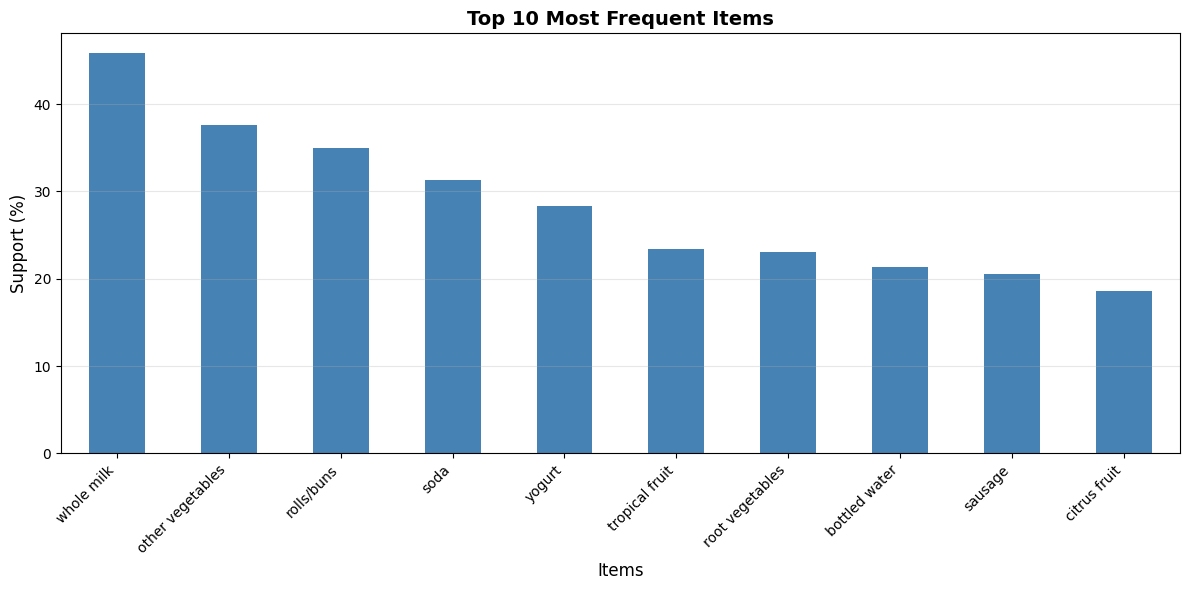

In [24]:
plt.figure(figsize=(12, 6))
item_support.head(10).plot(kind='bar', color='steelblue')
plt.title('Top 10 Most Frequent Items', fontsize=14, fontweight='bold')
plt.xlabel('Items', fontsize=12)
plt.ylabel('Support (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# APRIORI Algorithm

In [25]:
freq_items_apriori = apriori(df_encoded, min_support=0.01, use_colnames=True)
freq_items_apriori['length'] = freq_items_apriori['itemsets'].apply(lambda x: len(x))
freq_items_apriori = freq_items_apriori.sort_values('support', ascending=False)

print(f"Found {len(freq_items_apriori)} frequent itemsets\n")
print("Frequent itemsets by size:")
for size in sorted(freq_items_apriori['length'].unique()):
    count = (freq_items_apriori['length'] == size).sum()
    print(f"  Size {size}: {count} itemsets")

freq_items_apriori

Found 3016 frequent itemsets

Frequent itemsets by size:
  Size 1: 116 itemsets
  Size 2: 1126 itemsets
  Size 3: 1459 itemsets
  Size 4: 311 itemsets
  Size 5: 4 itemsets


,support,itemsets,length
113,0.46,(whole milk),1
69,0.38,(other vegetables),1
84,0.35,(rolls/buns),1
94,0.31,(soda),1
114,0.28,(yogurt),1
...,...,...,...
2467,0.01,"(other vegetables, whole milk, semi-finished b...",3
2471,0.01,"(other vegetables, shopping bags, white bread)",3
2073,0.01,"(other vegetables, pork, domestic eggs)",3
3014,0.01,"(whole milk, other vegetables, rolls/buns, sho...",5


* View Top Frequent Itemsets by Size

In [26]:
print("Top 5 single items:")
print("-" * 60)
single_items = freq_items_apriori[freq_items_apriori['length'] == 1].head()
for idx, row in single_items.iterrows():
    items = ', '.join(list(row['itemsets']))
    print(f"  {items:30s} → {row['support']*100:.1f}% support")

print("="*60)
print("Top 5 item pairs:")
print("-" * 60)
if len(freq_items_apriori[freq_items_apriori['length'] == 2]) > 0:
    pairs = freq_items_apriori[freq_items_apriori['length'] == 2].head()
    for idx, row in pairs.iterrows():
        items = ', '.join(list(row['itemsets']))
        print(f"  {items:30s} → {row['support']*100:.1f}% support")
else:
    print("No frequent item pairs found at this support level")

print("="*60)
print("Top item combinations (3+ items):")
print("-" * 60)
if len(freq_items_apriori[freq_items_apriori['length'] >= 3]) > 0:
    combos = freq_items_apriori[freq_items_apriori['length'] >= 3].head()
    for idx, row in combos.iterrows():
        items = ', '.join(list(row['itemsets']))
        print(f"  {items:30s} → {row['support']*100:.1f}% support")
else:
    print("No frequent combinations of 3+ items found")

Top 5 single items:
------------------------------------------------------------
  whole milk                     → 45.8% support
  other vegetables               → 37.7% support
  rolls/buns                     → 35.0% support
  soda                           → 31.3% support
  yogurt                         → 28.3% support
Top 5 item pairs:
------------------------------------------------------------
  other vegetables, whole milk   → 19.1% support
  rolls/buns, whole milk         → 17.9% support
  soda, whole milk               → 15.1% support
  yogurt, whole milk             → 15.1% support
  rolls/buns, other vegetables   → 14.7% support
Top item combinations (3+ items):
------------------------------------------------------------
  rolls/buns, whole milk, other vegetables → 8.2% support
  yogurt, whole milk, other vegetables → 7.2% support
  soda, other vegetables, whole milk → 6.9% support
  rolls/buns, whole milk, yogurt → 6.6% support
  soda, rolls/buns, whole milk   → 6.5% sup

# FP-GROWTH Algorithm

In [27]:
freq_items_fpgrowth = fpgrowth(df_encoded, min_support=0.01, use_colnames=True)
freq_items_fpgrowth['length'] = freq_items_fpgrowth['itemsets'].apply(lambda x: len(x))
freq_items_fpgrowth = freq_items_fpgrowth.sort_values('support', ascending=False)
print(f"Found {len(freq_items_fpgrowth)} frequent itemsets\n")

Found 3016 frequent itemsets



* Show summary by itemset size

In [28]:
print("Frequent itemsets by size:")
for size in sorted(freq_items_fpgrowth['length'].unique()):
    count = (freq_items_fpgrowth['length'] == size).sum()
    print(f"  Size {size}: {count} itemsets")

freq_items_fpgrowth

Frequent itemsets by size:
  Size 1: 116 itemsets
  Size 2: 1126 itemsets
  Size 3: 1459 itemsets
  Size 4: 311 itemsets
  Size 5: 4 itemsets


,support,itemsets,length
0,0.46,(whole milk),1
17,0.38,(other vegetables),1
11,0.35,(rolls/buns),1
1,0.31,(soda),1
2,0.28,(yogurt),1
...,...,...,...
1847,0.01,"(other vegetables, dessert, root vegetables)",3
2929,0.01,"(other vegetables, rolls/buns, ice cream)",3
2932,0.01,"(sausage, whole milk, ice cream)",3
2331,0.01,"(brown bread, other vegetables, frankfurter)",3


# Compare Apriori vs FP-Growth

In [29]:
print(f"Apriori found:    {len(freq_items_apriori)} frequent itemsets")
print(f"FP-Growth found:  {len(freq_items_fpgrowth)} frequent itemsets")

Apriori found:    3016 frequent itemsets
FP-Growth found:  3016 frequent itemsets


# Generate Association Rules (from Apriori)

In [30]:
rules = association_rules(freq_items_apriori, metric="confidence", min_threshold=0.5)
print(f"Generated {len(rules)} association rules\n")
rules = rules.sort_values('lift', ascending=False)
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

Generated 1117 association rules



,antecedents,consequents,support,confidence,lift
872,"(tropical fruit, rolls/buns, sausage)",(yogurt),0.01,0.53,1.88
1080,"(curd, whole milk, sausage)",(yogurt),0.01,0.53,1.86
545,"(sausage, rolls/buns, whole milk, other vegeta...",(yogurt),0.01,0.52,1.84
1007,"(meat, domestic eggs)",(whole milk),0.01,0.78,1.71
831,"(coffee, canned beer)",(soda),0.01,0.54,1.71
...,...,...,...,...,...
492,"(bottled water, pork)",(whole milk),0.01,0.50,1.09
791,"(soda, long life bakery product)",(whole milk),0.01,0.50,1.09
832,"(hygiene articles, rolls/buns)",(whole milk),0.01,0.50,1.09
821,"(yogurt, salty snack)",(whole milk),0.01,0.50,1.09


* Filter Strong Rules


> Strong Rules (support > 5%, confidence > 30%)





In [31]:
strong_rules = rules[(rules['support'] > 0.05) & (rules['confidence'] > 0.3)]
strong_rules = strong_rules.sort_values('confidence', ascending=False)

print(f"Found {len(strong_rules)} strong rules\n")

if len(strong_rules) > 0:
    print(strong_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])
else:
    print("No strong rules found at these thresholds.")


Found 30 strong rules

                           antecedents         consequents  support  \
25   (bottled water, other vegetables)        (whole milk)     0.06   
13          (yogurt, other vegetables)        (whole milk)     0.07   
19                (rolls/buns, yogurt)        (whole milk)     0.07   
10      (rolls/buns, other vegetables)        (whole milk)     0.08   
27                      (soda, yogurt)        (whole milk)     0.05   
16            (soda, other vegetables)        (whole milk)     0.07   
28  (tropical fruit, other vegetables)        (whole milk)     0.05   
20                  (soda, rolls/buns)        (whole milk)     0.07   
5                      (shopping bags)        (whole milk)     0.09   
29         (sausage, other vegetables)        (whole milk)     0.05   
9                       (bottled beer)        (whole milk)     0.09   
26                 (frozen vegetables)        (whole milk)     0.06   
21                              (beef)        (whole m

# Business Insights
* TOP SELLING ITEMS:

In [32]:
top_5 = freq_items_apriori[freq_items_apriori['length'] == 1].head()
for idx, row in top_5.iterrows():
    item = list(row['itemsets'])[0]
    print(f"   • {item}: appears in {row['support']*100:.1f}% of transactions")

   • whole milk: appears in 45.8% of transactions
   • other vegetables: appears in 37.7% of transactions
   • rolls/buns: appears in 35.0% of transactions
   • soda: appears in 31.3% of transactions
   • yogurt: appears in 28.3% of transactions


* Most common combinations

In [33]:
top_combos = freq_items_apriori[freq_items_apriori['length'] >= 2].head(5)
for idx, row in top_combos.iterrows():
    items = ' + '.join(list(row['itemsets']))
    print(f"   • {items}")
    print(f"     Support: {row['support']*100:.1f}%")

   • other vegetables + whole milk
     Support: 19.1%
   • rolls/buns + whole milk
     Support: 17.9%
   • soda + whole milk
     Support: 15.1%
   • yogurt + whole milk
     Support: 15.1%
   • rolls/buns + other vegetables
     Support: 14.7%


* STRONGEST PRODUCT ASSOCIATIONS

In [34]:
if len(rules) > 0:
    top_rules = rules.head(3)
    for i, (idx, row) in enumerate(top_rules.iterrows(), 1):
        ant = ', '.join(list(row['antecedents']))
        cons = ', '.join(list(row['consequents']))
        print(f"\n   Rule {i}: If customer buys {ant}")
        print(f"           → They're {row['lift']:.2f}x more likely to buy {cons}")
        print(f"           Confidence: {row['confidence']*100:.1f}%")


   Rule 1: If customer buys tropical fruit, rolls/buns, sausage
           → They're 1.88x more likely to buy yogurt
           Confidence: 53.1%

   Rule 2: If customer buys curd, whole milk, sausage
           → They're 1.86x more likely to buy yogurt
           Confidence: 52.7%

   Rule 3: If customer buys sausage, rolls/buns, whole milk, other vegetables
           → They're 1.84x more likely to buy yogurt
           Confidence: 52.0%


# Performance Comparison - Apriori vs FP-Growth

PERFORMANCE TEST
--------------------------------------------------------------------------------
Apriori execution time:    0.0366 seconds
FP-Growth execution time:  0.6655 seconds
Apriori is 18.16x FASTER than FP-Growth
VISUAL COMPARISON
--------------------------------------------------------------------------------


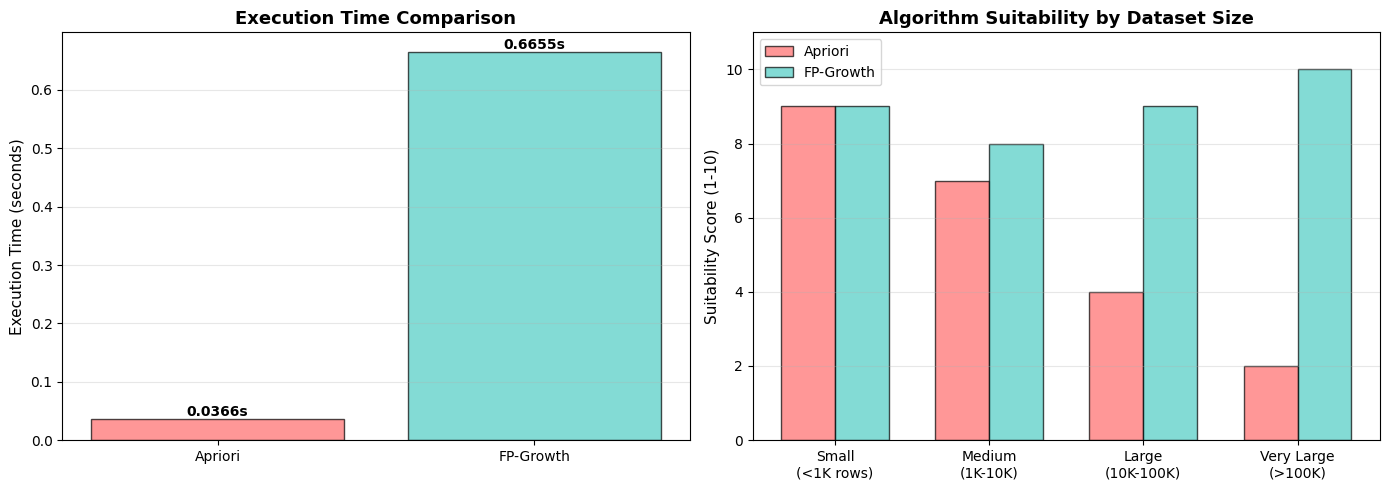

In [35]:
import time
print("PERFORMANCE TEST")
print("-" * 80)


start_time = time.time()
test_apriori = apriori(df_encoded, min_support=0.1, use_colnames=True)
apriori_time = time.time() - start_time

start_time = time.time()
test_fpgrowth = fpgrowth(df_encoded, min_support=0.1, use_colnames=True)
fpgrowth_time = time.time() - start_time

print(f"Apriori execution time:    {apriori_time:.4f} seconds")
print(f"FP-Growth execution time:  {fpgrowth_time:.4f} seconds")

if fpgrowth_time < apriori_time:
    speedup = apriori_time / fpgrowth_time
    print(f"FP-Growth is {speedup:.2f}x FASTER than Apriori")
else:
    speedup = fpgrowth_time / apriori_time
    print(f"Apriori is {speedup:.2f}x FASTER than FP-Growth")



print("VISUAL COMPARISON")
print("-" * 80)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Chart 1: Execution Time Comparison
algorithms = ['Apriori', 'FP-Growth']
times = [apriori_time, fpgrowth_time]
colors = ['#FF6B6B', '#4ECDC4']
axes[0].bar(algorithms, times, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Execution Time (seconds)', fontsize=11)
axes[0].set_title('Execution Time Comparison', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, (alg, t) in enumerate(zip(algorithms, times)):
    axes[0].text(i, t, f'{t:.4f}s', ha='center', va='bottom', fontweight='bold')


# Chart 2: Dataset Size Recommendations
dataset_sizes = ['Small\n(<1K rows)', 'Medium\n(1K-10K)', 'Large\n(10K-100K)', 'Very Large\n(>100K)']
apriori_scores = [9, 7, 4, 2]
fpgrowth_scores = [9, 8, 9, 10]
x = np.arange(len(dataset_sizes))
width = 0.35
axes[1].bar(x - width/2, apriori_scores, width, label='Apriori',
            color='#FF6B6B', alpha=0.7, edgecolor='black')
axes[1].bar(x + width/2, fpgrowth_scores, width, label='FP-Growth',
            color='#4ECDC4', alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Suitability Score (1-10)', fontsize=11)
axes[1].set_title('Algorithm Suitability by Dataset Size', fontsize=13, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(dataset_sizes)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim(0, 11)

plt.tight_layout()
plt.show()


## FEATURE COMPARISON: Apriori vs FP-Growth

---

| Feature | Apriori | FP-Growth |
|---------|---------|-----------|
| **Algorithm Type** | Candidate Generation | Tree-Based (FP-Tree) |
| **Database Scans** | Multiple (k+1 scans) | Only 2 scans |
| **Memory Usage** | Lower | Higher |
| **Speed (Small Data)** | Good | Good |
| **Speed (Large Data)** | Slower | Faster |
| **Ease of Understanding** | Easy to grasp | More complex |
| **Implementation Complexity** | Simpler | More complex |
| **Best Use Case** | Small-Medium datasets | Large datasets |
